<a href="https://colab.research.google.com/github/mrinalinimurugan/Tensorflow-with-Keras/blob/main/05_tf_transferlearning_part2_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Transfer learning with tensorflow Part 2: Fine tuning

!nvidia-smi

Sun Nov 14 10:06:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Creating helper fucnctions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-14 10:06:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-14 10:06:43 (67.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#Import helper functions 

from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,walk_through_dir


In [4]:
#Lets get some data
#Get 10% of training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-11-14 10:06:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 74.125.69.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   158MB/s    in 1.0s    

2021-11-14 10:06:48 (158 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#Check out how many images and subdirectories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [6]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE=32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [8]:
#Check out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.83571434e+01 1.43571424e+01 1.33571424e+01]
   [1.85714283e+01 1.45714293e+01 1.15714293e+01]
   [1.96428566e+01 1.56428576e+01 1.26428576e+01]
   ...
   [1.16785652e+02 9.97856522e+01 8.37856522e+01]
   [1.08969307e+02 8.99693069e+01 7.49693069e+01]
   [9.90305862e+01 8.00305862e+01 6.50305862e+01]]

  [[2.08826542e+01 1.68826542e+01 1.58826532e+01]
   [2.18571434e+01 1.78571434e+01 1.48571434e+01]
   [2.25000000e+01 1.85000000e+01 1.55000000e+01]
   ...
   [1.49999878e+02 1.33999878e+02 1.17999878e+02]
   [1.35438675e+02 1.18438675e+02 1.02438675e+02]
   [1.23908134e+02 1.06908134e+02 9.09081345e+01]]

  [[2.58622456e+01 2.18622456e+01 2.08622456e+01]
   [2.28163261e+01 1.88163261e+01 1.58163261e+01]
   [2.12346935e+01 1.72346935e+01 1.42346935e+01]
   ...
   [1.85550964e+02 1.72765259e+02 1.56765259e+02]
   [1.75499878e+02 1.62714157e+02 1.46714157e+02]
   [1.58862122e+02 1.44423431e+02 1.28928497e+02]]

  ...

  [[1.37143078e+01 1.47143078e+01 8.71430779e+00]
   [1

In [10]:
#Model 0:Building a transfer learning feature extraction model using the keras functional API

#Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#Freeze the base model
base_model.trainable=False

#Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#If using ResNet50V2 you will need to normalize inputs(Efficient has rescaling built in)
#x = tf.keras.layers.experimental.reprocessing.Rescaling(1/255.)(inputs)

#Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#Average pool the outputs of the base model
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#Output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#Combine inputs with the outputs into the model
model_0 = tf.keras.Model(inputs,outputs)

#Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback("trainsfer_learning",
                                                                         experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: trainsfer_learning/10_percent_feature_extraction/20211114-100701
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - 47s 449ms/step - loss: 1.8892 - accuracy: 0.4107 - val_loss: 1.3500 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 7s 265ms/step - loss: 1.1474 - accuracy: 0.7507 - val_loss: 0.9296 - val_accuracy: 0.7632
Epoch 3/5
24/24 [==============================] - 9s 354ms/step - loss: 0.8382 - accuracy: 0.8080 - val_loss: 0.7452 - val_accuracy: 0.8109
Epoch 4/5
24/24 [==============================] - 9s 355ms/step - loss: 0.6747 - accuracy: 0.8480 - val_loss: 0.6792 - val_accuracy: 0.8109
Epoch 5/5
24/24 [==============================] - 9s 354ms/step - loss: 0.5787 - accuracy: 0.8653 - val_loss: 0.6306 - val_accuracy: 0.8273


In [11]:
model_0.evaluate(test_data)

79/79 [==============================] - 11s 134ms/step - loss: 0.6096 - accuracy: 0.8368


[0.6096197962760925, 0.8367999792098999]

In [12]:
#Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [13]:
#Summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [14]:
#Summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


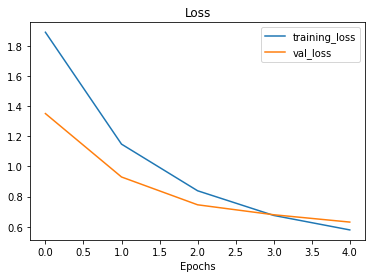

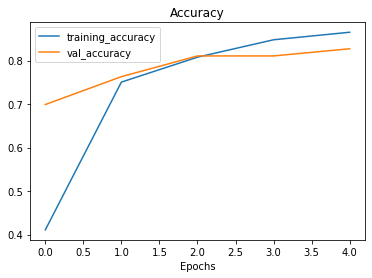

In [15]:
#Check out our models training curves
plot_loss_curves(history_10_percent)

In [16]:
#Getting a feature vector from a trained model

#Define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

#Pass the random tensor to a GlobalAvering Pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average polled random tensor:\n {global_average_pooled_tensor}")

print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of GAP2D: {global_average_pooled_tensor.shape} ")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average polled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of GAP2D: (1, 3) 


In [17]:
#Lets replicate the globalaveragepool2D layers
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [18]:
#Running a series of transfer learning experiments

#Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2021-11-14 10:08:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   180MB/s    in 0.7s    

2021-11-14 10:08:47 (180 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
unzip_data("10_food_classes_1_percent.zip")

In [20]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [21]:
#How many images are we working with

walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [22]:
#Setup data loaders
BATCH_SIZE=32
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [23]:
#Adding data augmentation right into the model
print(tf.__version__)

2.7.0


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescale(1./255)                                     
],name="data_augmentation")

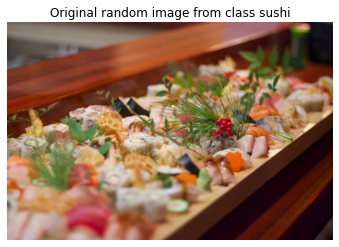

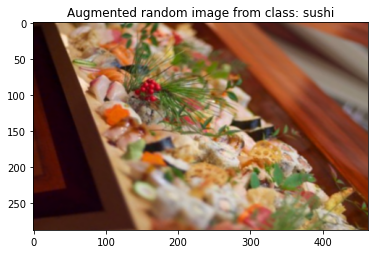

In [25]:
#View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

#Read random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

#Now lets plot augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.imshow(tf.squeeze(augmented_img)/255.)
#print(augmented_img)

In [26]:
#Model 1:Building a transfer learning feature extraction model for 1% data with data augmentation
#Set input shape and base model,freezing the base model layers
input_shape = (224,224,3)

#Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#Freeze the base model
base_model.trainable=False

#Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

#Add in data augmentation Sequential model as sa layer
x = data_augmentation(inputs)

#Give base model the inputs and dont train it
x = base_model(x,training=False)

#Average pool the outputs of the base model
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Output dense layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#Combine inputs with the outputs into the model
model_1 = tf.keras.Model(inputs,outputs)

#Compile for the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_1_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="1_percent_data_aug")])
                                           

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20211114-100853
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3/3 [==============================] - 14s 3s/step - loss: 2.4036 - accuracy: 0.0857 - val_loss: 2.2476 - val_accuracy: 0.1859
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1703 - accuracy: 0.2714 - val_loss: 2.1220 - val_accuracy: 0.2385
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 2.0015 - accuracy: 0.3571 - val_loss: 2.0395 - val_accuracy: 0.3043
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.8419 - accuracy: 0.5143 - val_loss: 1.9442 - val_accuracy: 0.3520
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6524 - accuracy: 0.6286 - val_loss: 1.8648 - val_accuracy: 0.3898


In [27]:
#Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [28]:
#Evaluate on full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 1.8545 - accuracy: 0.3992


[1.8545005321502686, 0.3991999924182892]

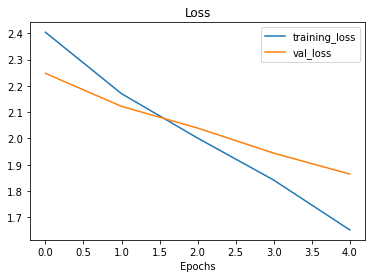

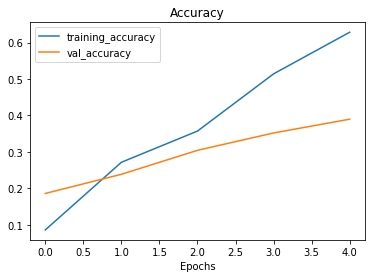

In [29]:
#Loss curves
plot_loss_curves(history_1_percent)

In [30]:
#Model 2:Building a transfer learning feature extraction model for 10% data with data augmentation
#Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

import tensorflow as tf
train_data_10_percent= tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)




Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
#Set input shape and base model,freezing the base model layers
input_shape = (224,224,3)

#Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#Freeze the base model
base_model.trainable=False

#Create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name="input_layer")

#Add in data augmentation Sequential model as sa layer
x = data_augmentation(inputs)

#Give base model the inputs and dont train it
x = base_model(x,training=False)

#Average pool the outputs of the base model
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Output dense layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#Combine inputs with the outputs into the model
model_2 = tf.keras.Model(inputs,outputs)

#Compile for the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Creating model checkpoint
#Set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights.checkpoint.ckpt"

#save model weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1)

#Fit the model
history_10_percent_aug = model_2.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=int(0.25*len(test_data)),
                                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name="10_percent_data_aug"),checkpoint_callback])
                                           

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211114-100951
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


24/24 [==============================] - ETA: 0s - loss: 1.9917 - accuracy: 0.3467
Epoch 00001: saving model to ten_percent_model_checkpoints_weights.checkpoint.ckpt
24/24 [==============================] - 26s 769ms/step - loss: 1.9917 - accuracy: 0.3467 - val_loss: 1.4767 - val_accuracy: 0.6743
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3572 - accuracy: 0.6693
Epoch 00002: saving model to ten_percent_model_checkpoints_weights.checkpoint.ckpt
24/24 [==============================] - 14s 572ms/step - loss: 1.3572 - accuracy: 0.6693 - val_loss: 1.0399 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.7613
Epoch 00003: saving model to ten_percent_model_checkpoints_weights.checkpoint.ckpt
24/24 [==============================] - 17s 676ms/step - loss: 1.0478 - accuracy: 0.7613 - val_loss: 0.8471 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 

In [32]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 0.6879 - accuracy: 0.8036


[0.6879335045814514, 0.803600013256073]

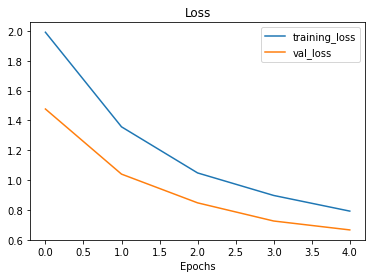

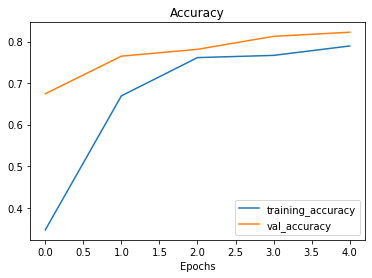

In [33]:
plot_loss_curves(history_10_percent_aug)

In [34]:
#Loading in checkpoints and weights 
#Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [35]:
#Evaluate mode_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.6879 - accuracy: 0.8036


In [36]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [37]:
results_10_percent_data_aug

[0.6879335045814514, 0.803600013256073]

In [38]:
loaded_weights_model_results

[0.6879334449768066, 0.803600013256073]

In [39]:
#Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [40]:
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


In [41]:
#Model 3:Fine tuning an existing on 10% of data

model_2.layers

In [42]:
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f21914604d0> True
<keras.engine.sequential.Sequential object at 0x7f2194d10d10> True
<keras.engine.functional.Functional object at 0x7f22051e2c10> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f22056c3790> True
<keras.layers.core.dense.Dense object at 0x7f2205381b90> True


In [43]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [44]:
print(len(model_2.layers[2].trainable_variables))

0


In [45]:
#To begin fine tuning lets start by setting the last 10 layers to our bas_model.trainable=True
base_model.trainable=True
#Freeze all layers except 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [46]:
#Check which layers are trainable/tunable
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [47]:
#Unfrozen someof the layers closer to the top
print(len(model_2.trainable_variables))

12


In [48]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

In [49]:
#Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs+5

#Refit the model 
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=fine_tune_epochs,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_10_percent_aug.epoch[-1],
                                             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                                         experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20211114-101201


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 5/10
24/24 [==============================] - 27s 723ms/step - loss: 0.6598 - accuracy: 0.8093 - val_loss: 0.5613 - val_accuracy: 0.8174
Epoch 6/10
24/24 [==============================] - 13s 513ms/step - loss: 0.5676 - accuracy: 0.8200 - val_loss: 0.4980 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 13s 531ms/step - loss: 0.5015 - accuracy: 0.8440 - val_loss: 0.5235 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 14s 583ms/step - loss: 0.4567 - accuracy: 0.8627 - val_loss: 0.4770 - val_accuracy: 0.8421
Epoch 9/10
24/24 [==============================] - 12s 498ms/step - loss: 0.3872 - accuracy: 0.8760 - val_loss: 0.4985 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 14s 552ms/step - loss: 0.3663 - accuracy: 0.8933 - val_loss: 0.4960 - val_accuracy: 0.8405


In [50]:
#Evaluate the fine-tunes model
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.4938 - accuracy: 0.8316


In [51]:
results_10_percent_data_aug

[0.6879335045814514, 0.803600013256073]

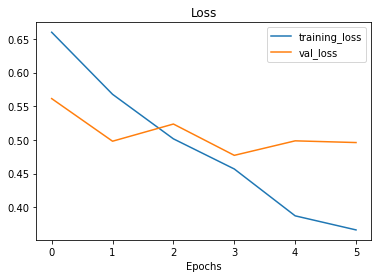

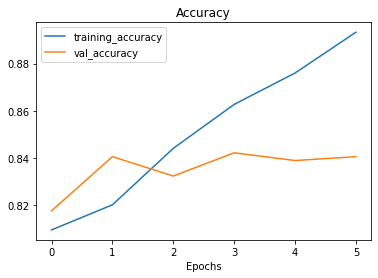

In [52]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [53]:
#Lets create a function to compare training histories
def compare_historys(original_history,new_history,initial_epochs=5):
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc=acc + new_history.history["accuracy"]
  total_loss=loss + new_history.history["loss"]

  total_val_acc=val_acc + new_history.history["val_accuracy"]
  total_val_loss=val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training Accuracy")
  plt.plot(total_val_acc,label="val Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training loss")
  plt.plot(total_val_loss,label="val loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Loss")  

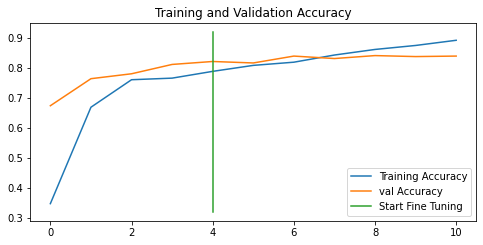

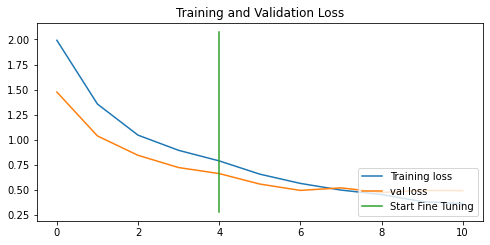

In [54]:
compare_historys(history_10_percent_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [55]:
#Model 4:Fine tuning existing model on all the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-11-14 10:14:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   160MB/s    in 3.1s    

2021-11-14 10:14:13 (160 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [56]:
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [57]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.

In [58]:
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [59]:
#Evaluate model 2 
model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.4938 - accuracy: 0.8316


[0.4937838912010193, 0.83160001039505]

In [60]:
results_fine_tune_10_percent

[0.4937838017940521, 0.83160001039505]

In [61]:
#Load weights from checkpoint
model_2.load_weights(checkpoint_path)

In [62]:
model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.6879 - accuracy: 0.8036


[0.6879333853721619, 0.803600013256073]

In [63]:
results_10_percent_data_aug

[0.6879335045814514, 0.803600013256073]

In [64]:
#Check which layers are tunable
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [65]:
for layer_number,layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [66]:
#compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
#Continue to train and fine tune on 100%data
initial_epochs=5
fine_tune_epochs =initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_fine_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                  experiment_name="full+10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full+10_classes_fine_tune_last_10/20211114-101454


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 10/10
235/235 [==============================] - 91s 352ms/step - loss: 0.7187 - accuracy: 0.7659 - val_loss: 0.4187 - val_accuracy: 0.8651


In [68]:
#Lets evaluate on all of test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 129ms/step - loss: 0.4204 - accuracy: 0.8584


[0.42041659355163574, 0.8583999872207642]

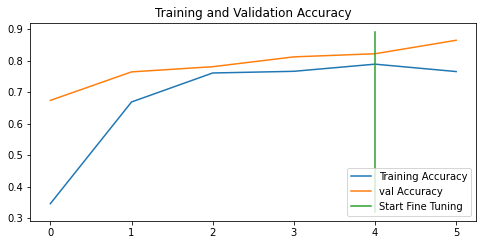

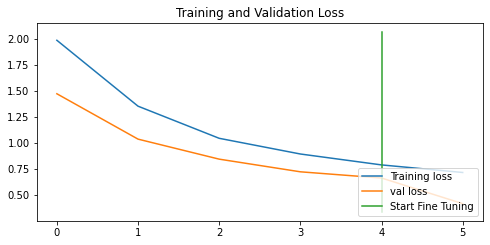

In [69]:
#How did fine-tuning go with more data
compare_historys(original_history=history_10_percent_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [70]:
#View our expt data on tensorboard
!tensorboard dev upload --logdir ./transfer_learning\
  --name "Transfer Learning Expts with 10 Food101 Classes"\
  --description "A series of different transfer learning experiments with varying amounts of data and fine tuning"\
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=gV8HxrqnbYF3ITHE2pg3URCOQdUqVO&prompt=consent&access_type=o

In [71]:
!tensorboard dev list

https://tensorboard.dev/experiment/awwmNdOXR6K9IGqhB3YDZw/
	Name                 Transfer Learning Expts with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine tuning
	Id                   awwmNdOXR6K9IGqhB3YDZw
	Created              2021-11-14 10:18:31 (32 seconds ago)
	Updated              2021-11-14 10:18:35 (28 seconds ago)
	Runs                 8
	Tags                 5
	Scalars              102
	Tensor bytes         0
	Binary object bytes  3378102
https://tensorboard.dev/experiment/pSEhEedGQzWYV9OL9LSLAw/
	Name                 Transfer Learning Expts with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine tuning
	Id                   pSEhEedGQzWYV9OL9LSLAw
	Created              2021-11-12 17:32:03
	Updated              2021-11-12 17:32:20
	Runs                 25
	Tags                 5
	Scalars              258
	Tensor b

In [72]:
#To delete an expt
#!tensorboard dev delete --experiment id pSEhEedGQzWYV9OL9LSLAw